<h1>3rd Try </h1>

In [140]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import SelectKBest, f_classif , chi2

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

from sklearn.model_selection import train_test_split

import imblearn

from imblearn.over_sampling import SMOTE

import xgboost as xgb

from sklearn import tree

from sklearn.ensemble import GradientBoostingClassifier

In [141]:
# ignore warnings

import warnings
warnings.filterwarnings('ignore')

In [142]:
df_features = pd.read_csv('data/train_values.csv',index_col='building_id')
df_target = pd.read_csv('data/train_labels.csv',index_col='building_id')

df_test= pd.read_csv('data/test_values.csv',index_col='building_id')

In [143]:
print(df_features.shape)
print(df_target.shape)

(260601, 38)
(260601, 1)


In [144]:
num_features= df_features.select_dtypes(np.number)

obj_features= df_features.select_dtypes('object')



<h3>Remover variables constantes</h3>

In [145]:
# using sklearn variancethreshold to find constant features

from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=0)
sel.fit(num_features)  # fit finds the features with zero variance

VarianceThreshold(threshold=0)

In [146]:
# get_support is a boolean vector that indicates which features are retained
# if we sum over get_support, we get the number of features that are not constant
sum(sel.get_support())

30

<h5> Todas las variables numéricas no son constantes </h5>

<h3>Remover variables que tienen poca variabilidad</h3>

In [147]:
sel = VarianceThreshold(threshold=0.01)  # 0.1 indicates 99% of observations approximately

sel.fit(num_features)  # fit finds the features with low variance

VarianceThreshold(threshold=0.01)

In [148]:
# get_support is a boolean vector that indicates which features 
# are retained. If we sum over get_support, we get the number
# of features that are not quasi-constant
sum(sel.get_support())

22

In [149]:
# finally we can print the quasi-constant features
print(
    len([
        x for x in num_features.columns
        if x not in num_features.columns[sel.get_support()]
    ]))

[x for x in num_features.columns if x not in num_features.columns[sel.get_support()]]

8


['has_secondary_use_rental',
 'has_secondary_use_institution',
 'has_secondary_use_school',
 'has_secondary_use_industry',
 'has_secondary_use_health_post',
 'has_secondary_use_gov_office',
 'has_secondary_use_use_police',
 'has_secondary_use_other']

We can see that 8 columns / variables are almost constant. This means that 8 variables show predominantly one value for ~99% the observations of the training set.

In [150]:
#ejemplo de la variabilidad de las categorias dentro de un feature/variable

df_features['has_secondary_use_rental'].value_counts()/len(df_features)

0    0.991899
1    0.008101
Name: has_secondary_use_rental, dtype: float64

In [151]:
#removemos los features tanto del train como del test

df_features.drop(['has_secondary_use_rental',
 'has_secondary_use_institution',
 'has_secondary_use_school',
 'has_secondary_use_industry',
 'has_secondary_use_health_post',
 'has_secondary_use_gov_office',
 'has_secondary_use_use_police',
 'has_secondary_use_other'],axis=1,inplace=True)



In [152]:
df_test.drop(['has_secondary_use_rental',
 'has_secondary_use_institution',
 'has_secondary_use_school',
 'has_secondary_use_industry',
 'has_secondary_use_health_post',
 'has_secondary_use_gov_office',
 'has_secondary_use_use_police',
 'has_secondary_use_other'],axis=1,inplace=True)

In [153]:
print(df_features.shape)
print(df_test.shape)

(260601, 30)
(86868, 30)


In [154]:
df_features.describe()

geo_level_1_id  geo_level_2_id  geo_level_3_id  count_floors_pre_eq  \
count   260601.000000   260601.000000   260601.000000        260601.000000   
mean        13.900353      701.074685     6257.876148             2.129723   
std          8.033617      412.710734     3646.369645             0.727665   
min          0.000000        0.000000        0.000000             1.000000   
25%          7.000000      350.000000     3073.000000             2.000000   
50%         12.000000      702.000000     6270.000000             2.000000   
75%         21.000000     1050.000000     9412.000000             2.000000   
max         30.000000     1427.000000    12567.000000             9.000000   

                 age  area_percentage  height_percentage  \
count  260601.000000    260601.000000      260601.000000   
mean       26.535029         8.018051           5.434365   
std        73.565937         4.392231           1.918418   
min         0.000000         1.000000           2.000000   
25%        10.000000         5.000000           4.000000   
50%        15.000000         7.000000           5.000000   
75%        30.000000         9.000000           6.000000   
max       995.000000       100.000000          32.000000   

       has_superstructure_adobe_mud  has_superstructure_mud_mortar_stone  \
count                 260601.000000                        260601.000000   
mean                       0.088645                             0.761935   
std                        0.284231                             0.425900   
min                        0.000000                             0.000000   
25%                        0.000000                             1.000000   
50%                        0.000000                             1.000000   
75%                        0.000000                             1.000000   
max                        1.000000                             1.000000   

       has_superstructure_stone_flag  ...  \
count                  260601.000000  ...   
mean                        0.034332  ...   
std                         0.182081  ...   
min                         0.000000  ...   
25%                         0.000000  ...   
50%                         0.000000  ...   
75%                         0.000000  ...   
max                         1.000000  ...   

       has_superstructure_cement_mortar_brick  has_superstructure_timber  \
count                           260601.000000              260601.000000   
mean                                 0.075268                   0.254988   
std                                  0.263824                   0.435855   
min                                  0.000000                   0.000000   
25%                                  0.000000                   0.000000   
50%                                  0.000000                   0.000000   
75%                                  0.000000                   1.000000   
max                                  1.000000                   1.000000   

       has_superstructure_bamboo  has_superstructure_rc_non_engineered  \
count              260601.000000                         260601.000000   
mean                    0.085011                              0.042590   
std                     0.278899                              0.201931   
min                     0.000000                              0.000000   
25%                     0.000000                              0.000000   
50%                     0.000000                              0.000000   
75%                     0.000000                              0.000000   
max                     1.000000                              1.000000   

       has_superstructure_rc_engineered  has_superstructure_other  \
count                     260601.000000             260601.000000   
mean                           0.015859                  0.014985   
std                            0.124932                  0.121491   
min                            0.000000     

In [155]:
df_features['age'].describe()

count    260601.000000
mean         26.535029
std          73.565937
min           0.000000
25%          10.000000
50%          15.000000
75%          30.000000
max         995.000000
Name: age, dtype: float64

In [156]:
#Age column has a value 995, we are going to drop it

#df_features.drop(df_features[df_features['age'].isin([200,195,200,995])].index,inplace=True)



In [157]:
df_features.describe()

geo_level_1_id  geo_level_2_id  geo_level_3_id  count_floors_pre_eq  \
count   260601.000000   260601.000000   260601.000000        260601.000000   
mean        13.900353      701.074685     6257.876148             2.129723   
std          8.033617      412.710734     3646.369645             0.727665   
min          0.000000        0.000000        0.000000             1.000000   
25%          7.000000      350.000000     3073.000000             2.000000   
50%         12.000000      702.000000     6270.000000             2.000000   
75%         21.000000     1050.000000     9412.000000             2.000000   
max         30.000000     1427.000000    12567.000000             9.000000   

                 age  area_percentage  height_percentage  \
count  260601.000000    260601.000000      260601.000000   
mean       26.535029         8.018051           5.434365   
std        73.565937         4.392231           1.918418   
min         0.000000         1.000000           2.000000   
25%        10.000000         5.000000           4.000000   
50%        15.000000         7.000000           5.000000   
75%        30.000000         9.000000           6.000000   
max       995.000000       100.000000          32.000000   

       has_superstructure_adobe_mud  has_superstructure_mud_mortar_stone  \
count                 260601.000000                        260601.000000   
mean                       0.088645                             0.761935   
std                        0.284231                             0.425900   
min                        0.000000                             0.000000   
25%                        0.000000                             1.000000   
50%                        0.000000                             1.000000   
75%                        0.000000                             1.000000   
max                        1.000000                             1.000000   

       has_superstructure_stone_flag  ...  \
count                  260601.000000  ...   
mean                        0.034332  ...   
std                         0.182081  ...   
min                         0.000000  ...   
25%                         0.000000  ...   
50%                         0.000000  ...   
75%                         0.000000  ...   
max                         1.000000  ...   

       has_superstructure_cement_mortar_brick  has_superstructure_timber  \
count                           260601.000000              260601.000000   
mean                                 0.075268                   0.254988   
std                                  0.263824                   0.435855   
min                                  0.000000                   0.000000   
25%                                  0.000000                   0.000000   
50%                                  0.000000                   0.000000   
75%                                  0.000000                   1.000000   
max                                  1.000000                   1.000000   

       has_superstructure_bamboo  has_superstructure_rc_non_engineered  \
count              260601.000000                         260601.000000   
mean                    0.085011                              0.042590   
std                     0.278899                              0.201931   
min                     0.000000                              0.000000   
25%                     0.000000                              0.000000   
50%                     0.000000                              0.000000   
75%                     0.000000                              0.000000   
max                     1.000000                              1.000000   

       has_superstructure_rc_engineered  has_superstructure_other  \
count                     260601.000000             260601.000000   
mean                           0.015859                  0.014985   
std                            0.124932                  0.121491   
min                            0.000000     

In [158]:
df=df_features.join(df_target)

In [159]:
df.shape

(260601, 31)

In [160]:
len(df[df['age']>120])

1734

In [161]:
df = df[df['age']<=120]

In [162]:
df.shape

(258867, 31)

<AxesSubplot: xlabel='age', ylabel='count'>

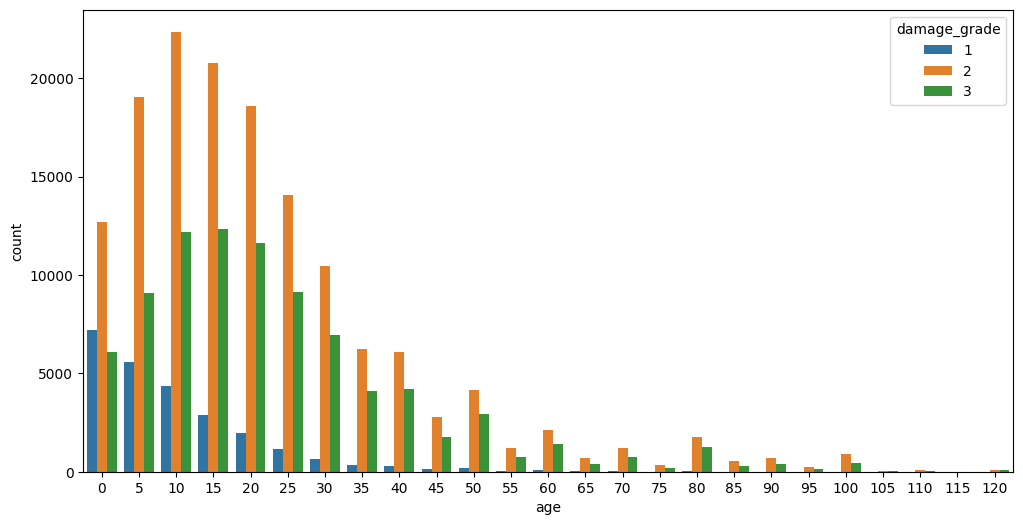

In [163]:
plt.rcParams['figure.figsize']=12,6

sns.countplot(data=df,x='age',hue='damage_grade')

<h3>Categorical feature selection</h3>

In [164]:
df.select_dtypes('object').columns

Index(['land_surface_condition', 'foundation_type', 'roof_type',
       'ground_floor_type', 'other_floor_type', 'position',
       'plan_configuration', 'legal_ownership_status'],
      dtype='object')

In [165]:
categorical_columns=df.select_dtypes('object')

object_cols = df.select_dtypes('object').columns


<AxesSubplot: xlabel='legal_ownership_status', ylabel='count'>

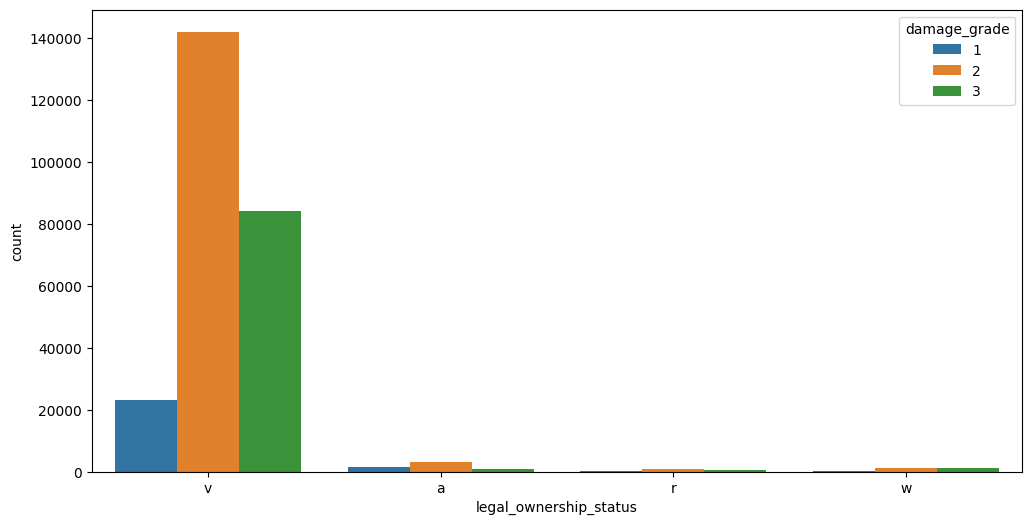

In [166]:
sns.countplot(data=df,x='legal_ownership_status',hue='damage_grade')

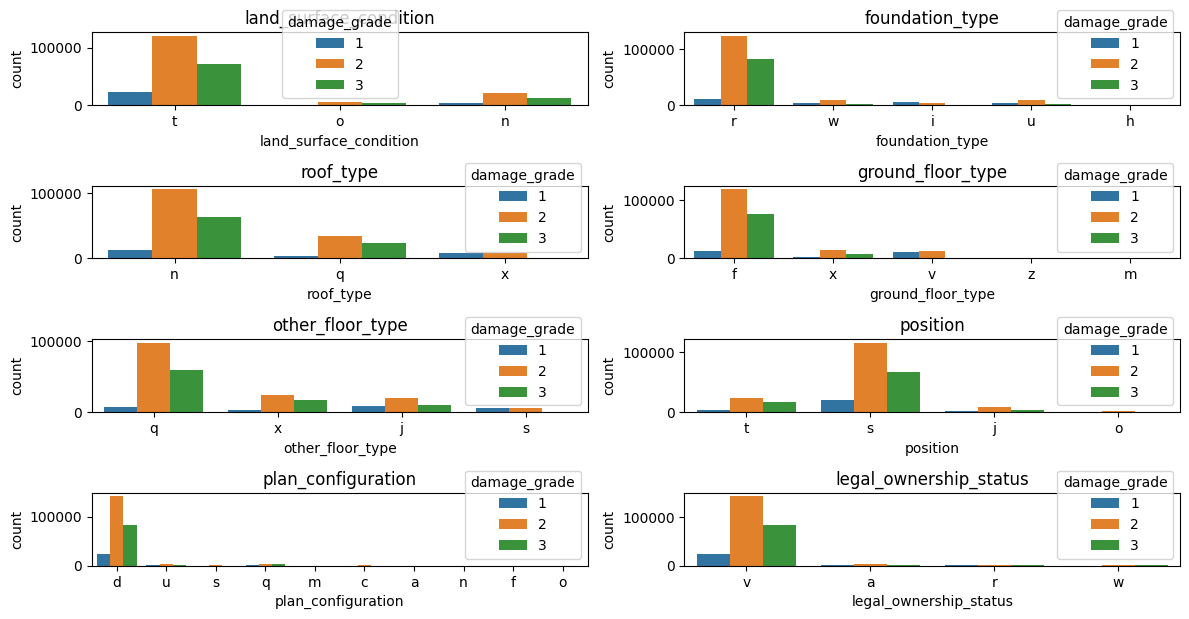

In [167]:
fig = plt.figure(figsize=(12,12))
for i, col in enumerate(object_cols):
    plt.subplot(len(object_cols), 2, i+1)
    
    ax=sns.countplot(x=col,hue='damage_grade', data=df)
    ax.set_title(col)

plt.tight_layout()
plt.show()

In [168]:
categorical_columns=pd.get_dummies(categorical_columns)

In [169]:
categorical_columns

land_surface_condition_n  land_surface_condition_o  \
building_id                                                       
802906                              0                         0   
28830                               0                         1   
94947                               0                         0   
590882                              0                         0   
201944                              0                         0   
...                               ...                       ...   
688636                              1                         0   
669485                              0                         0   
602512                              0                         0   
151409                              0                         0   
747594                              1                         0   

             land_surface_condition_t  foundation_type_h  foundation_type_i  \
building_id                                                                   
802906                              1                  0                  0   
28830                               0                  0                  0   
94947                               1                  0                  0   
590882                              1                  0                  0   
201944                              1                  0                  0   
...                               ...                ...                ...   
688636                              0                  0                  0   
669485                              1                  0                  0   
602512                              1                  0                  0   
151409                              1                  0                  0   
747594                              0                  0                  0   

             foundation_type_r  foundation_type_u  foundation_type_w  \
building_id                                                            
802906                       1                  0                  0   
28830                        1                  0                  0   
94947                        1                  0                  0   
590882                       1                  0                  0   
201944                       1                  0                  0   
...                        ...                ...                ...   
688636                       1                  0                  0   
669485                       1                  0                  0   
602512                       1                  0                  0   
151409                       1                  0                  0   
747594                       1                  0                  0   

             roof_type_n  roof_type_q  ...  plan_configuration_m  \
building_id                            ...                         
802906                 1            0  ...                     0   
28830                  1            0  ...                     0   
94947                  1            0  ...                     0   
590882                 1            0  ...                     0   
201944                 1            0  ...                     0   
...                  ...          ...  ...                   ...   
688636                 1            0  ...                     0   
669485                 1            0  ...                     0   
602512                 0            1  ...                     0   
151409                 0            0  ...                     0   
747594                 1            0  ...                     0   

             plan_configuration_n  plan_configuration_o  plan_configuration_q  \
building_id                                                                     
802906                          0                     0                     0   
28830                           0               

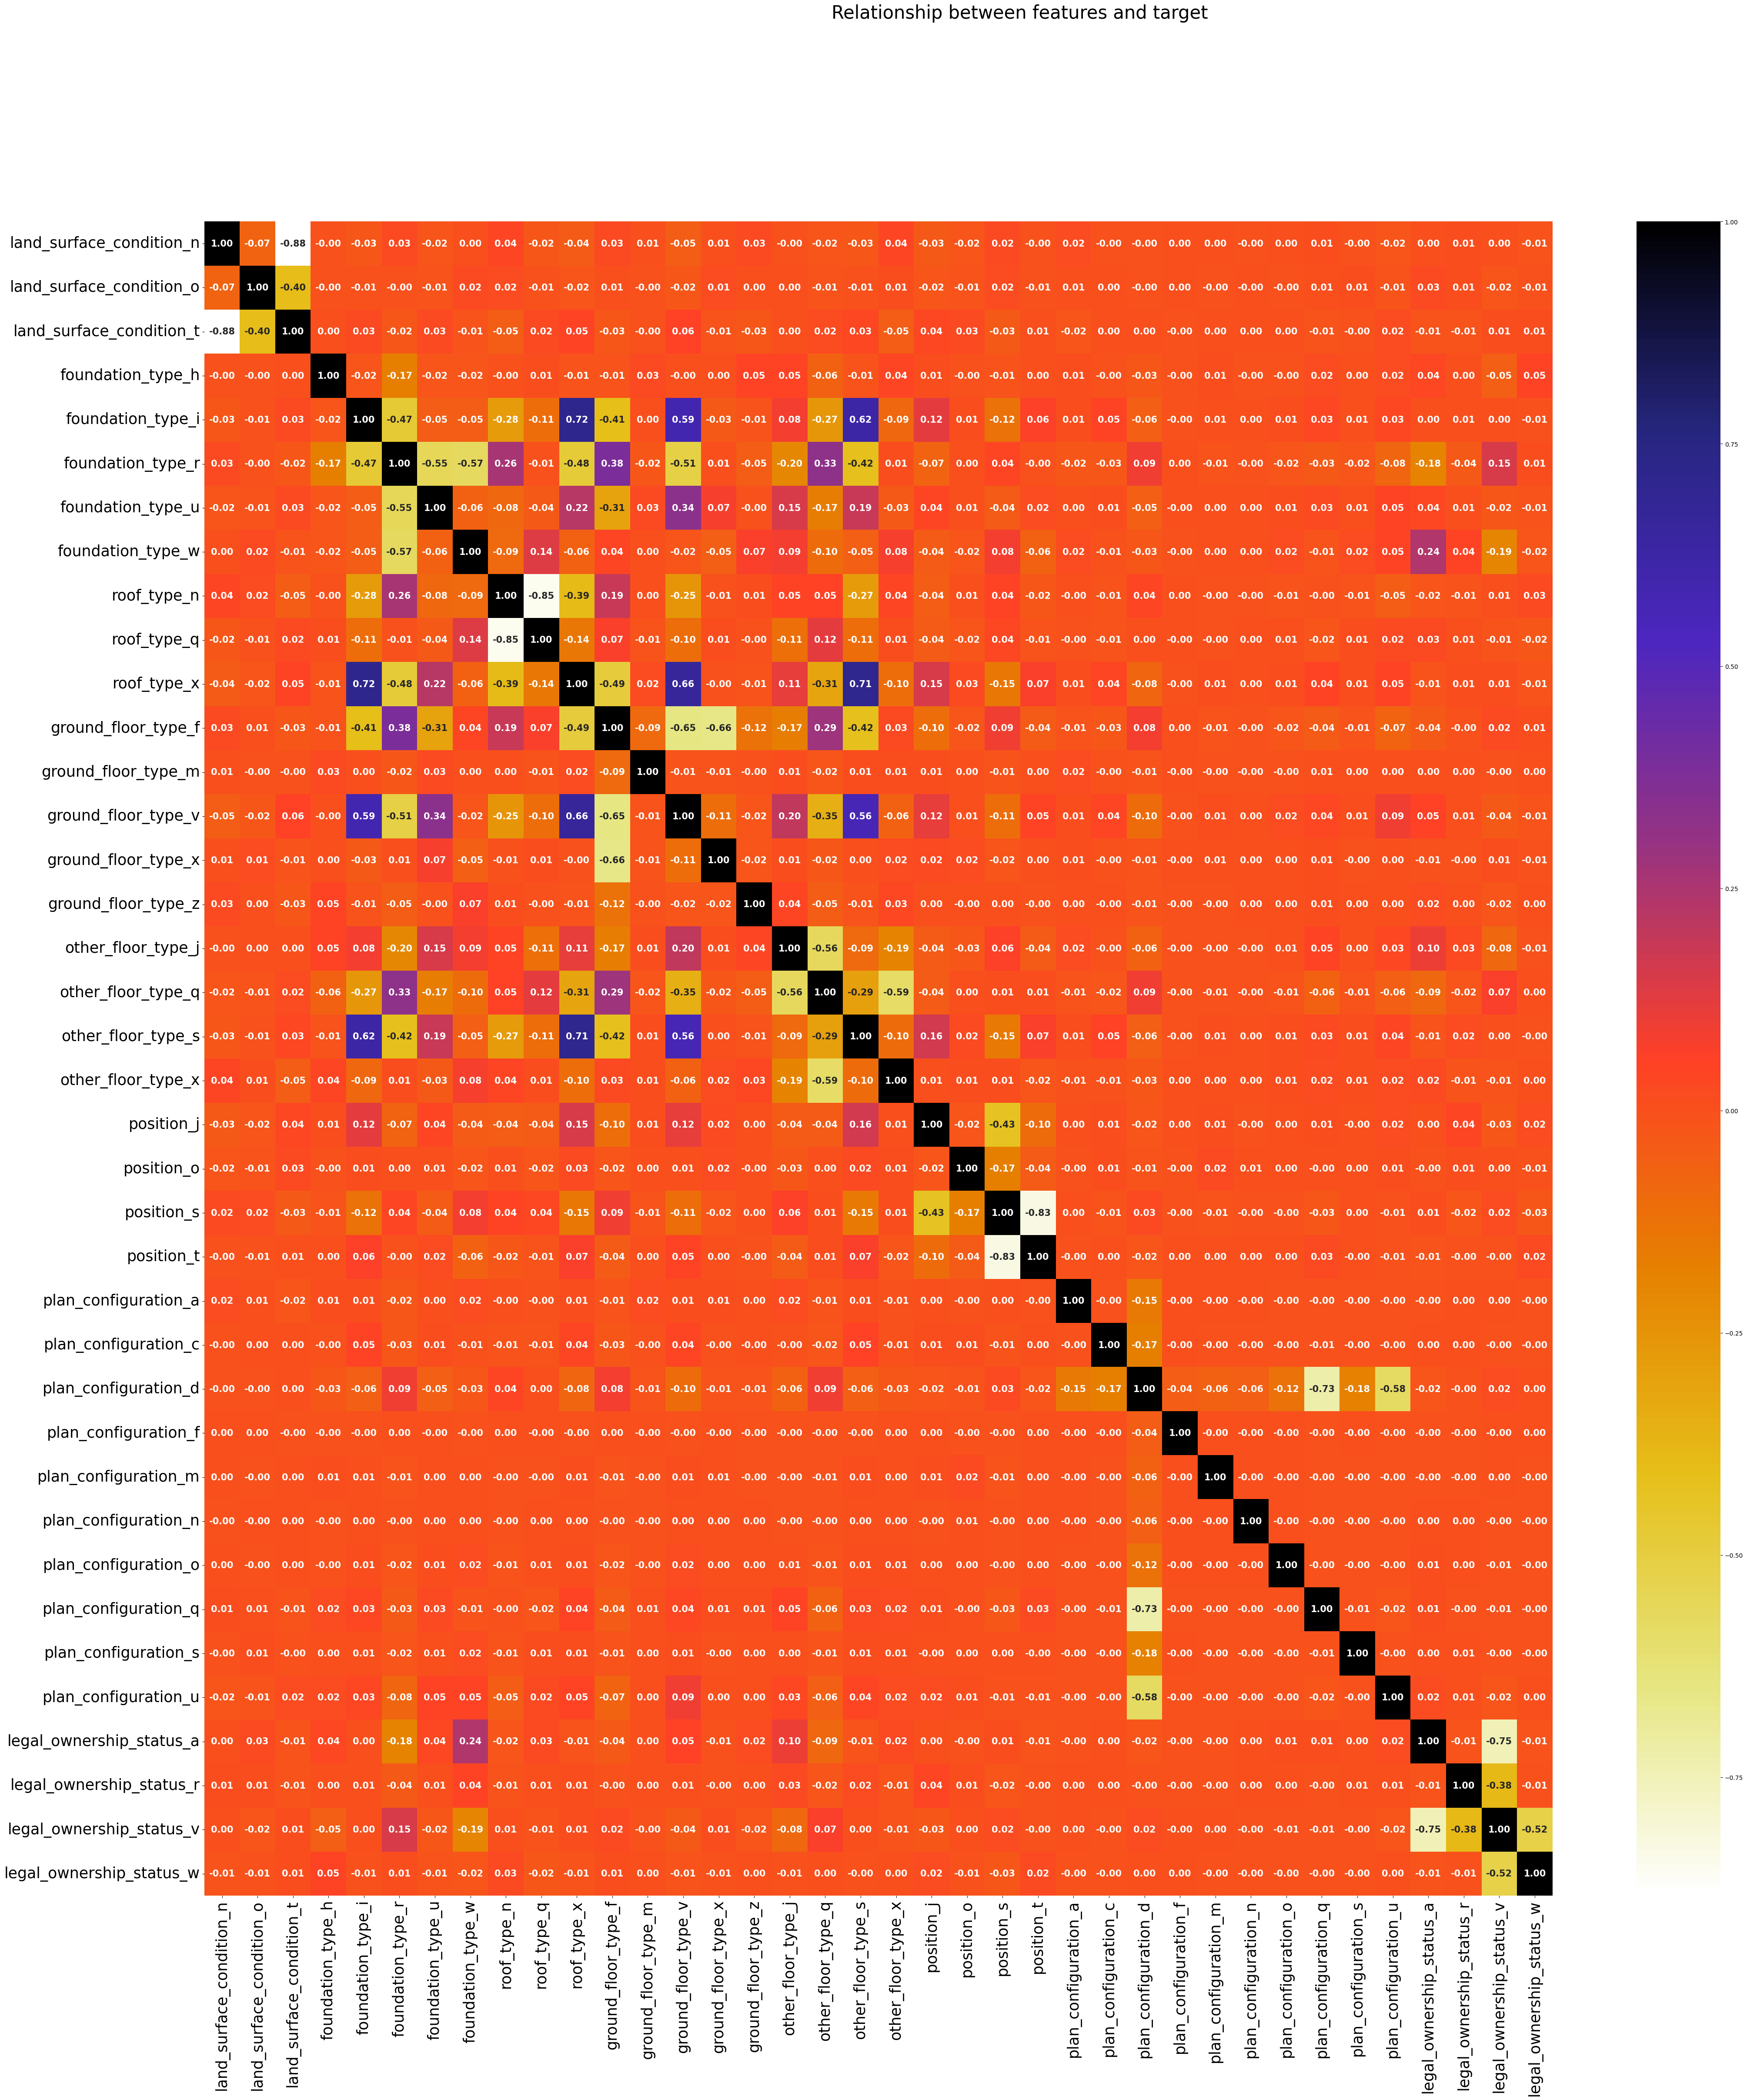

In [170]:
fig, ax= plt.subplots(figsize=(50,50))
sns.heatmap(categorical_columns.corr(),annot=True,annot_kws={'size': 15,'weight': 'bold'},cmap='CMRmap_r',fmt=".2f")
plt.suptitle("Relationship between features and target",size=30)
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)

plt.show()


In [171]:
categorical_columns.corrwith(df['damage_grade'])

land_surface_condition_n    0.008564
land_surface_condition_o    0.015027
land_surface_condition_t   -0.014923
foundation_type_h          -0.017355
foundation_type_i          -0.264573
foundation_type_r           0.344469
foundation_type_u          -0.139351
foundation_type_w          -0.173904
roof_type_n                 0.079150
roof_type_q                 0.074205
roof_type_x                -0.280536
ground_floor_type_f         0.235319
ground_floor_type_m        -0.019420
ground_floor_type_v        -0.319204
ground_floor_type_x         0.006553
ground_floor_type_z        -0.017772
other_floor_type_j         -0.136364
other_floor_type_q          0.167533
other_floor_type_s         -0.227136
other_floor_type_x          0.043243
position_j                 -0.032609
position_o                 -0.004395
position_s                 -0.027723
position_t                  0.051511
plan_configuration_a       -0.019405
plan_configuration_c       -0.023437
plan_configuration_d        0.043378
p

In [172]:
categorical_columns.drop(['land_surface_condition_n','land_surface_condition_o','land_surface_condition_t','foundation_type_h','ground_floor_type_m',
                            'ground_floor_type_x','ground_floor_type_z','position_o','plan_configuration_a','legal_ownership_status_r',
                            'plan_configuration_f','plan_configuration_m','plan_configuration_n','plan_configuration_o',
                            'plan_configuration_q','plan_configuration_s','legal_ownership_status_r'],axis=1,inplace=True)

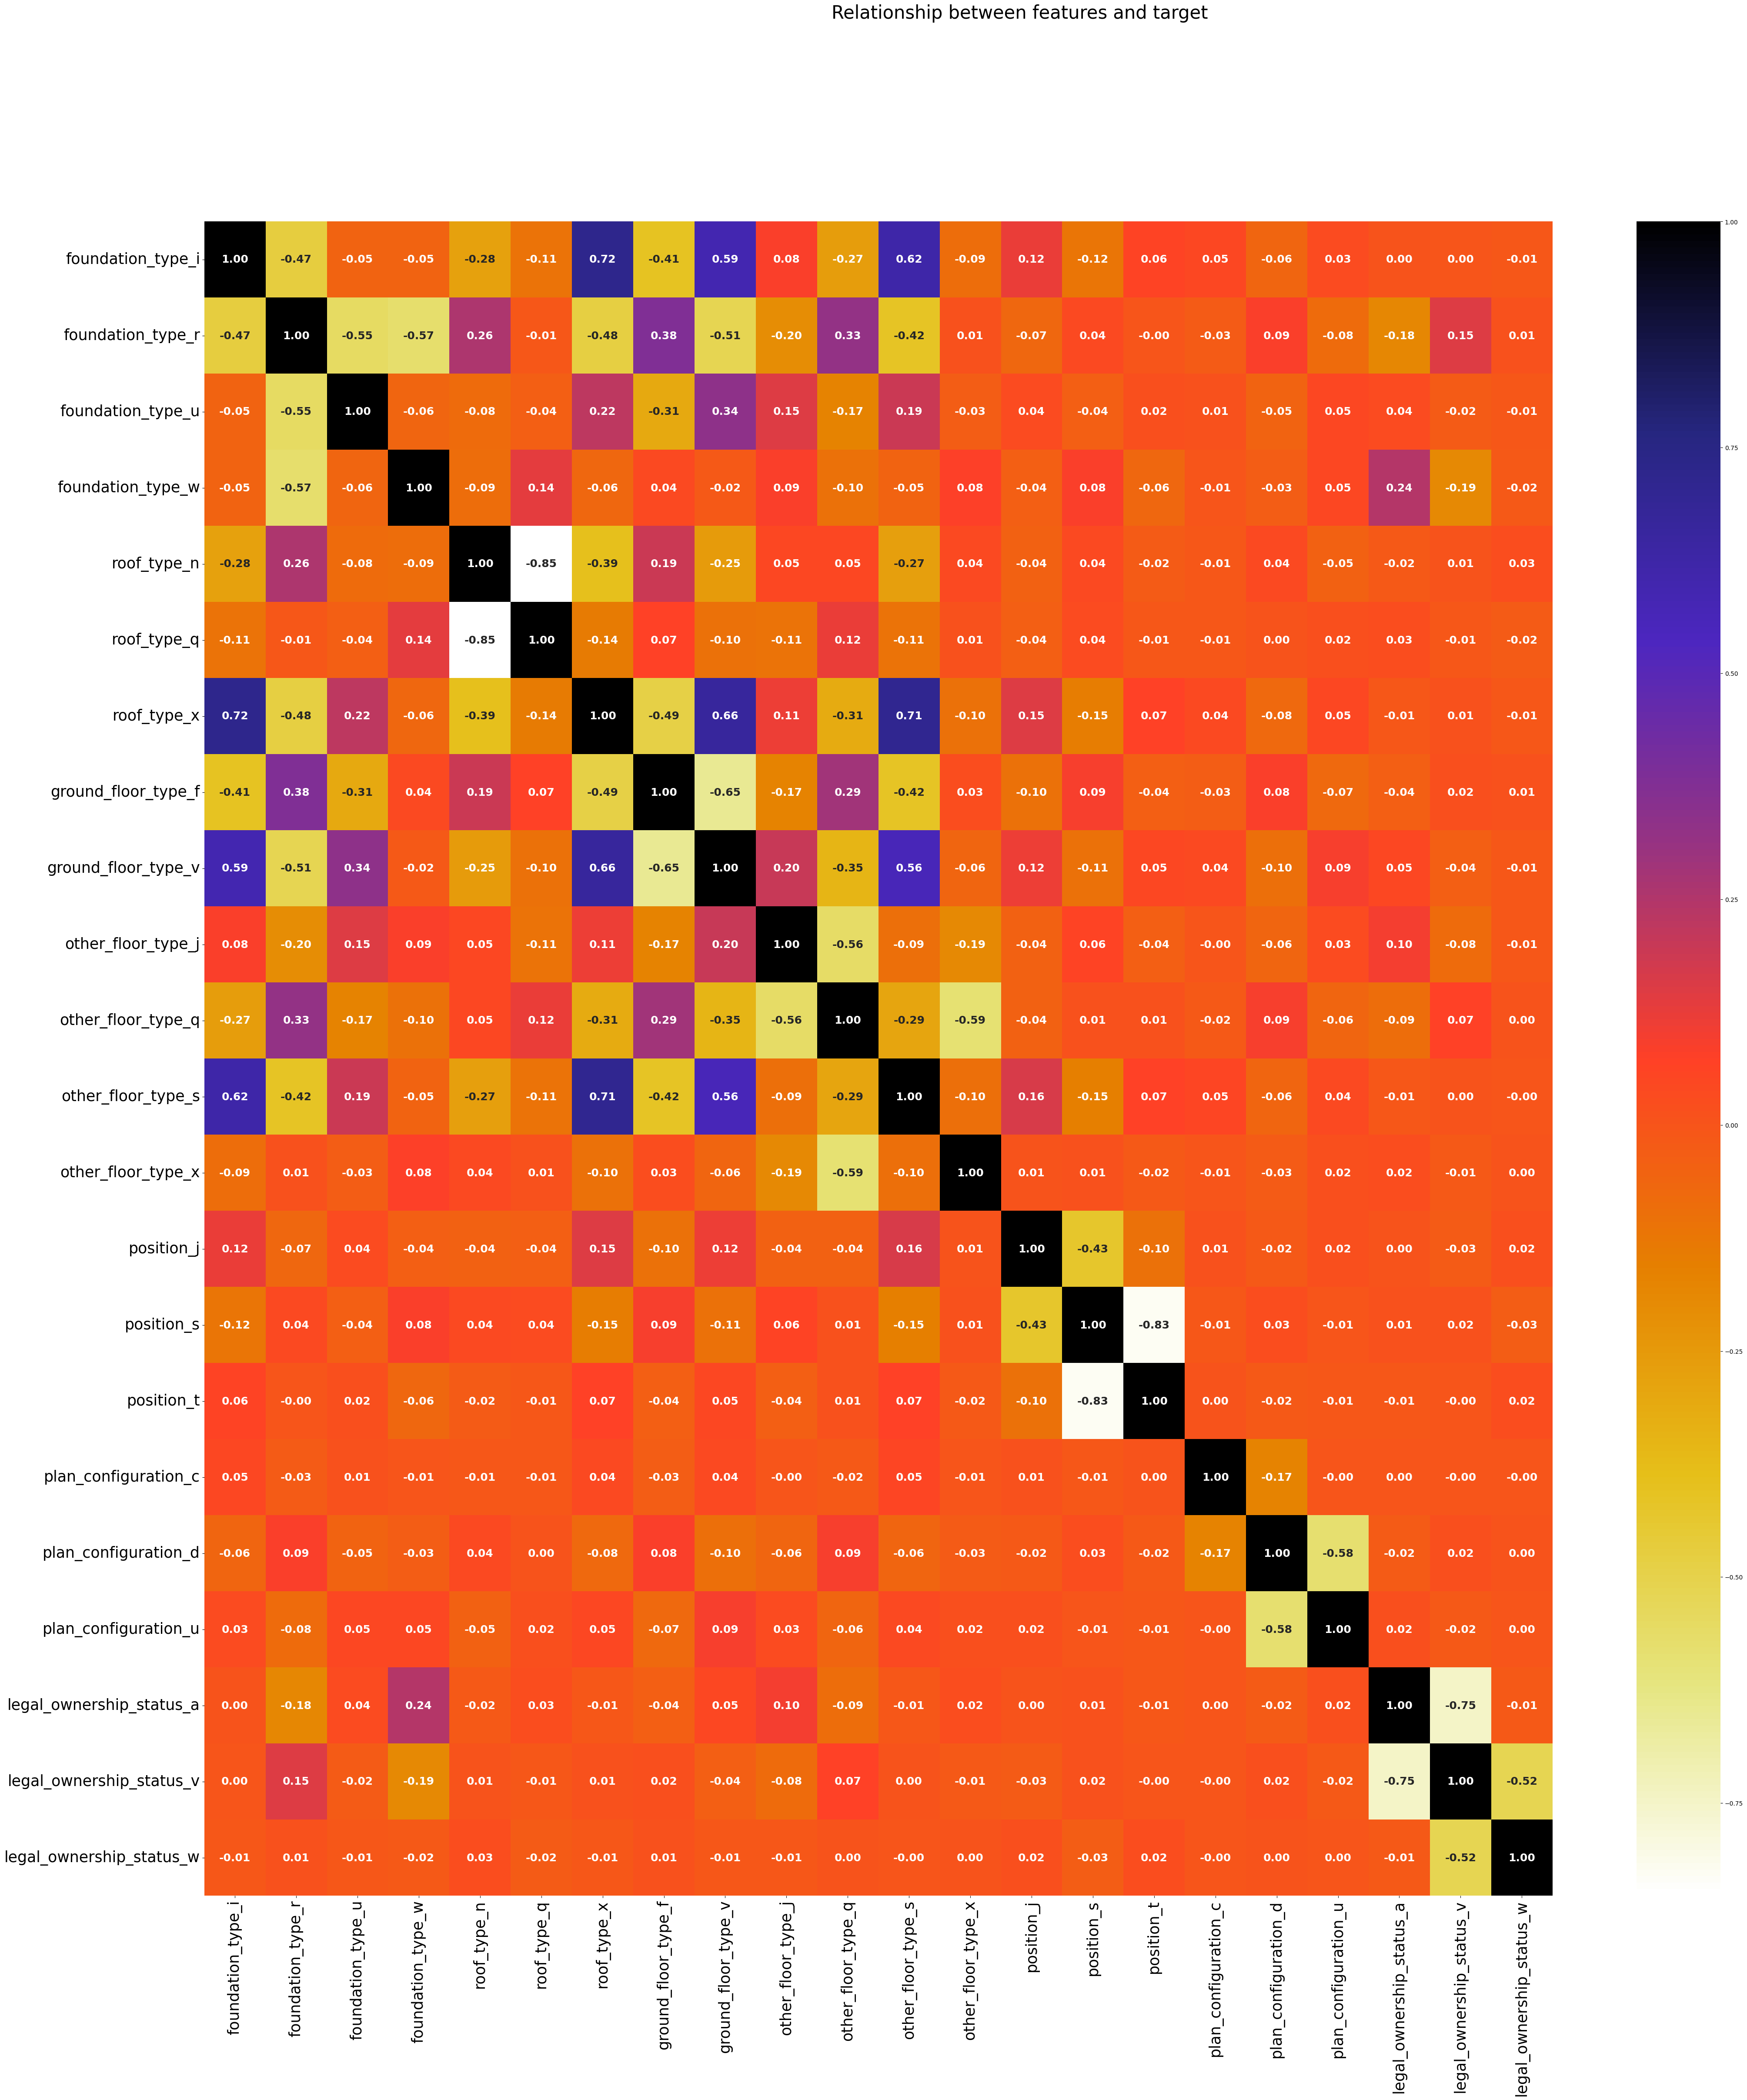

In [173]:
fig, ax= plt.subplots(figsize=(50,50))
sns.heatmap(categorical_columns.corr(),annot=True,annot_kws={'size': 18,'weight': 'bold'},cmap='CMRmap_r',fmt=".2f")
plt.suptitle("Relationship between features and target",size=30)
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)

plt.show()


In [174]:
categorical_columns.drop(['foundation_type_i','other_floor_type_s'],axis=1,inplace=True)

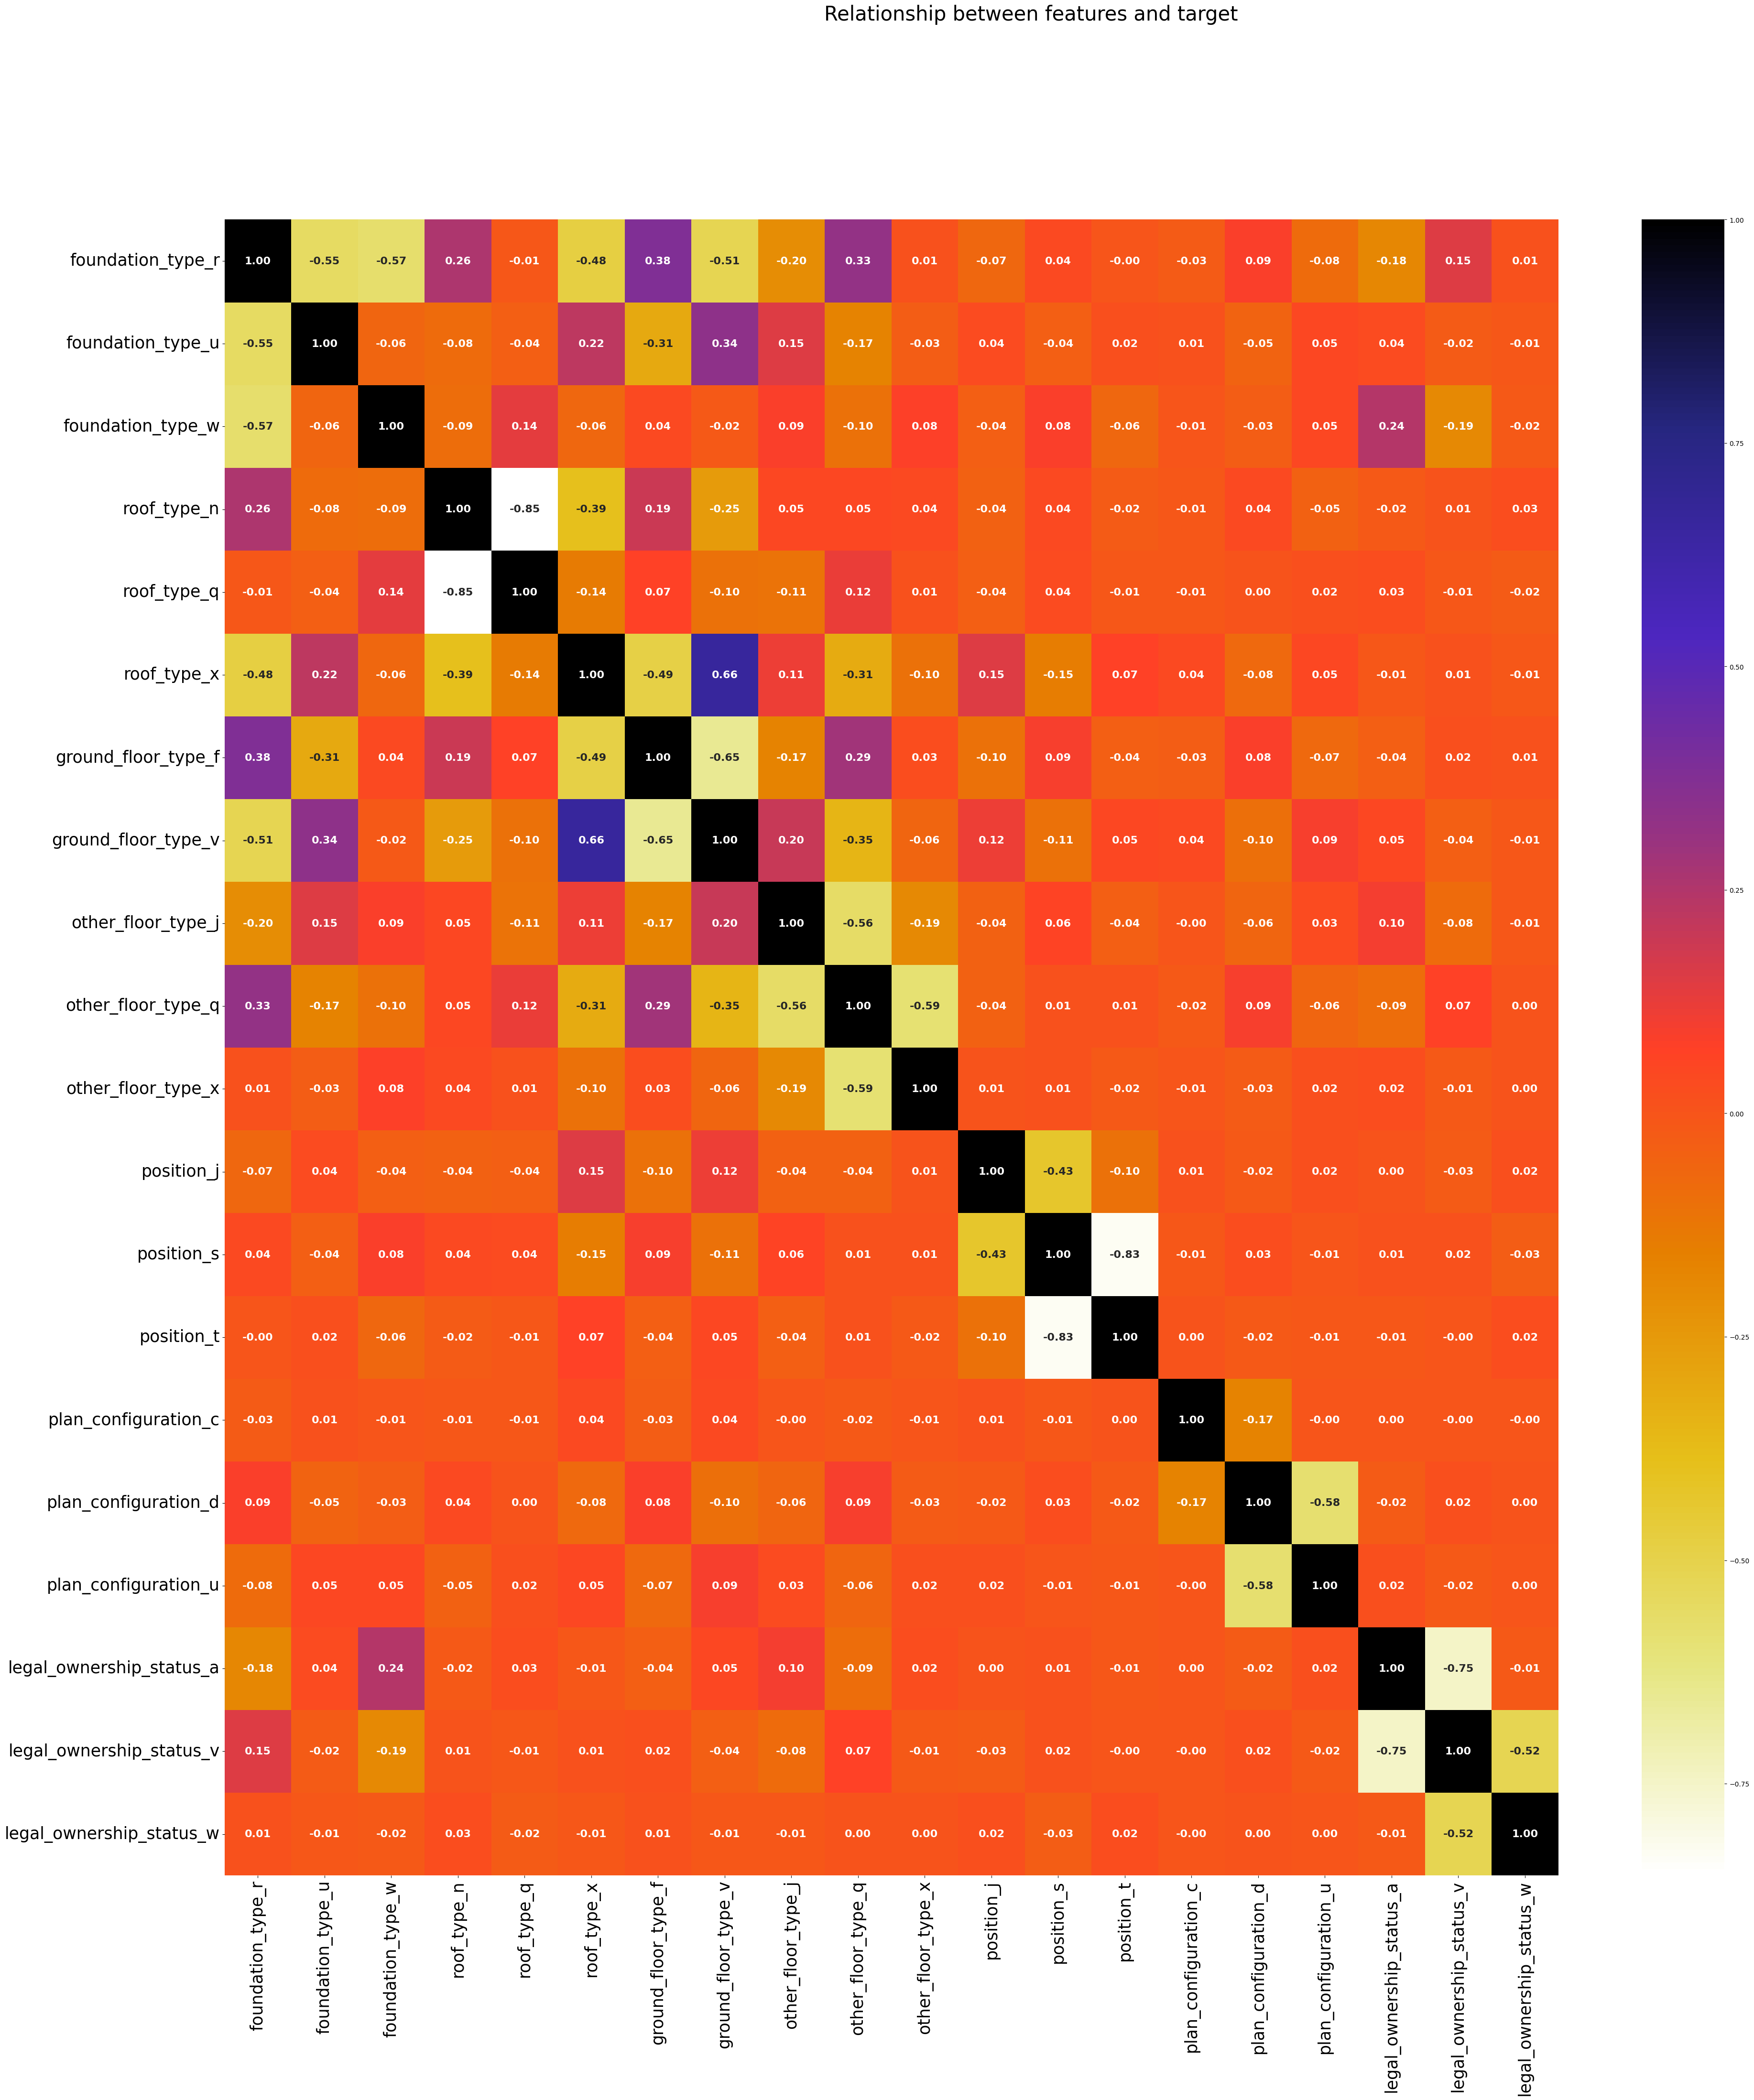

In [175]:
fig, ax= plt.subplots(figsize=(45,45))
sns.heatmap(categorical_columns.corr(),annot=True,annot_kws={'size': 16,'weight': 'bold'},cmap='CMRmap_r',fmt=".2f")
plt.suptitle("Relationship between features and target",size=30)
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)

plt.show()

In [176]:
categorical_columns.shape

(258867, 20)

In [177]:
categorical_columns

foundation_type_r  foundation_type_u  foundation_type_w  \
building_id                                                            
802906                       1                  0                  0   
28830                        1                  0                  0   
94947                        1                  0                  0   
590882                       1                  0                  0   
201944                       1                  0                  0   
...                        ...                ...                ...   
688636                       1                  0                  0   
669485                       1                  0                  0   
602512                       1                  0                  0   
151409                       1                  0                  0   
747594                       1                  0                  0   

             roof_type_n  roof_type_q  roof_type_x  ground_floor_type_f  \
building_id                                                               
802906                 1            0            0                    1   
28830                  1            0            0                    0   
94947                  1            0            0                    1   
590882                 1            0            0                    1   
201944                 1            0            0                    1   
...                  ...          ...          ...                  ...   
688636                 1            0            0                    1   
669485                 1            0            0                    1   
602512                 0            1            0                    1   
151409                 0            0            1                    0   
747594                 1            0            0                    1   

             ground_floor_type_v  other_floor_type_j  other_floor_type_q  \
building_id                                                                
802906                         0                   0                   1   
28830                          0                   0                   1   
94947                          0                   0                   0   
590882                         0                   0                   0   
201944                         0                   0                   0   
...                          ...                 ...                 ...   
688636                         0                   1                   0   
669485                         0                   0                   1   
602512                         0                   0                   1   
151409                         1                   0                   0   
747594                         0                   0                   1   

             other_floor_type_x  position_j  position_s  position_t  \
building_id                                                           
802906                        0           0           0           1   
28830                         0           0           1           0   
94947                         1           0           0           1   
590882                        1           0           1           0   
201944                        1           0           1           0   
...                         ...         ...         ...         ...   
688636                        0           0           1           0   
669485                        0           0           1           0   
602512                        0           0           1           0   
151409                        0           1           0           0   
747594                        0           1           0           0   

             plan_configuration_c  plan_configuration_d  plan_configuration_u  \
building_id                                                                     
802906                   

In [178]:
numerical_columns = df_features.select_dtypes(np.number)

In [179]:
df_def = numerical_columns.join(categorical_columns)

In [180]:
df_def

geo_level_1_id  geo_level_2_id  geo_level_3_id  \
building_id                                                   
802906                    6             487           12198   
28830                     8             900            2812   
94947                    21             363            8973   
590882                   22             418           10694   
201944                   11             131            1488   
...                     ...             ...             ...   
688636                   25            1335            1621   
669485                   17             715            2060   
602512                   17              51            8163   
151409                   26              39            1851   
747594                   21               9            9101   

             count_floors_pre_eq  age  area_percentage  height_percentage  \
building_id                                                                 
802906                         2   30                6                  5   
28830                          2   10                8                  7   
94947                          2   10                5                  5   
590882                         2   10                6                  5   
201944                         3   30                8                  9   
...                          ...  ...              ...                ...   
688636                         1   55                6                  3   
669485                         2    0                6                  5   
602512                         3   55                6                  7   
151409                         2   10               14                  6   
747594                         3   10                7                  6   

             has_superstructure_adobe_mud  \
building_id                                 
802906                                  1   
28830                                   0   
94947                                   0   
590882                                  0   
201944                                  1   
...                                   ...   
688636                                  0   
669485                                  0   
602512                                  0   
151409                                  0   
747594                                  0   

             has_superstructure_mud_mortar_stone  \
building_id                                        
802906                                         1   
28830                                          1   
94947                                          1   
590882                                         1   
201944                                         0   
...                                          ...   
688636                                         1   
669485                                         1   
602512                                         1   
151409                                         0   
747594                                         1   

             has_superstructure_stone_flag  ...  other_floor_type_x  \
building_id                                 ...                       
802906                                   0  ...                 0.0   
28830                                    0  ...                 0.0   
94947                                    0  ...                 1.0   
590882                                   0  ...                 1.0   
201944                                   0  ...                 1.0   
...                                    ...  ...                 ...   
688636                                   0  ...                 0.0   
669485                                   0  ...                 0.0   
602512                                   0  ...                 0.0   
151409                                   0  ...                 0.0   
747594                                   0  ...                 0.0   

    

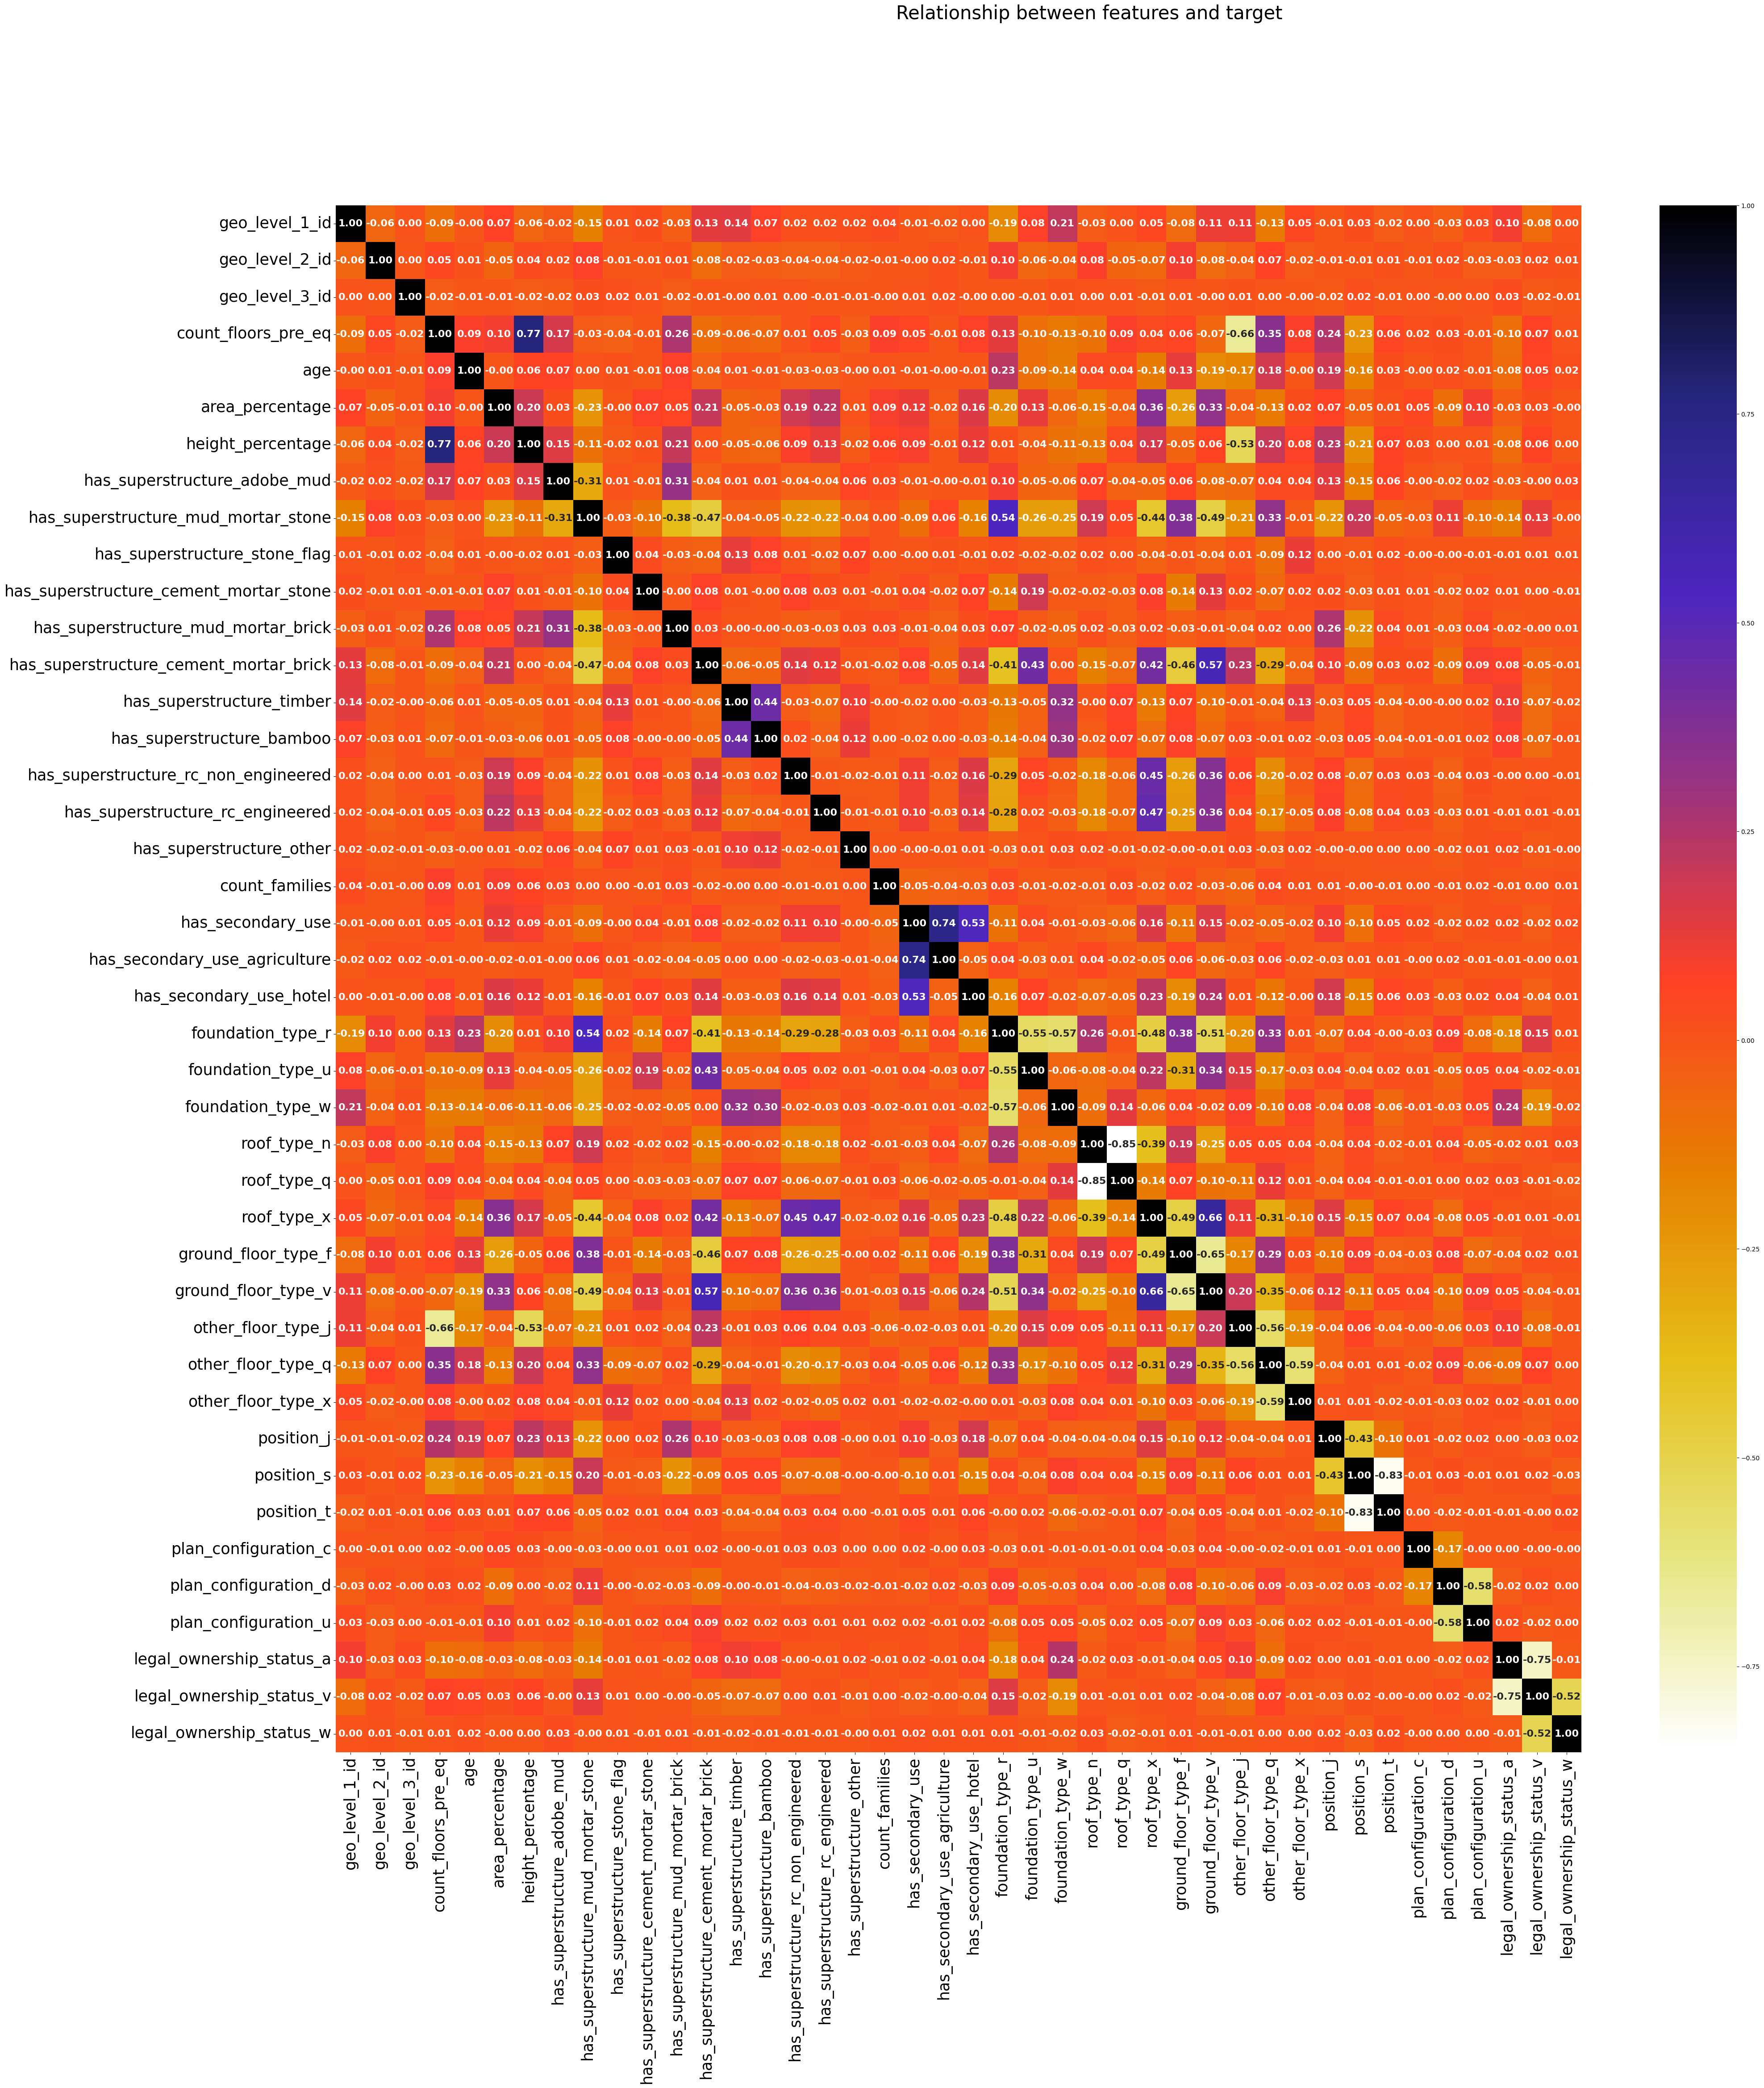

In [181]:
fig, ax= plt.subplots(figsize=(45,45))
sns.heatmap(df_def.corr(),annot=True,annot_kws={'size': 16,'weight': 'bold'},cmap='CMRmap_r',fmt=".2f")
plt.suptitle("Relationship between features and target",size=30)
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)

plt.show()

In [182]:
df_def.corrwith(df['damage_grade'])

geo_level_1_id                           -0.072424
geo_level_2_id                            0.042910
geo_level_3_id                            0.007834
count_floors_pre_eq                       0.123385
age                                       0.152949
area_percentage                          -0.125080
height_percentage                         0.048613
has_superstructure_adobe_mud              0.055952
has_superstructure_mud_mortar_stone       0.292142
has_superstructure_stone_flag             0.066543
has_superstructure_cement_mortar_stone   -0.060596
has_superstructure_mud_mortar_brick       0.014813
has_superstructure_cement_mortar_brick   -0.254680
has_superstructure_timber                -0.069097
has_superstructure_bamboo                -0.062345
has_superstructure_rc_non_engineered     -0.158470
has_superstructure_rc_engineered         -0.179367
has_superstructure_other                 -0.029934
count_families                            0.056040
has_secondary_use              

In [183]:
df_def.drop(['geo_level_3_id', 'has_superstructure_mud_mortar_brick','has_secondary_use_agriculture'],axis=1,inplace=True)

In [184]:
df_def.corrwith(df['damage_grade'])

geo_level_1_id                           -0.072424
geo_level_2_id                            0.042910
count_floors_pre_eq                       0.123385
age                                       0.152949
area_percentage                          -0.125080
height_percentage                         0.048613
has_superstructure_adobe_mud              0.055952
has_superstructure_mud_mortar_stone       0.292142
has_superstructure_stone_flag             0.066543
has_superstructure_cement_mortar_stone   -0.060596
has_superstructure_cement_mortar_brick   -0.254680
has_superstructure_timber                -0.069097
has_superstructure_bamboo                -0.062345
has_superstructure_rc_non_engineered     -0.158470
has_superstructure_rc_engineered         -0.179367
has_superstructure_other                 -0.029934
count_families                            0.056040
has_secondary_use                        -0.079997
has_secondary_use_hotel                  -0.097765
foundation_type_r              

In [185]:
df_def.shape

(260601, 39)

In [186]:

#FALTA PREPROCESSING DEL TEST SET

# get dummies y drop features

In [187]:
df_def.columns

Index(['geo_level_1_id', 'geo_level_2_id', 'count_floors_pre_eq', 'age',
       'area_percentage', 'height_percentage', 'has_superstructure_adobe_mud',
       'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
       'has_superstructure_cement_mortar_stone',
       'has_superstructure_cement_mortar_brick', 'has_superstructure_timber',
       'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered',
       'has_superstructure_rc_engineered', 'has_superstructure_other',
       'count_families', 'has_secondary_use', 'has_secondary_use_hotel',
       'foundation_type_r', 'foundation_type_u', 'foundation_type_w',
       'roof_type_n', 'roof_type_q', 'roof_type_x', 'ground_floor_type_f',
       'ground_floor_type_v', 'other_floor_type_j', 'other_floor_type_q',
       'other_floor_type_x', 'position_j', 'position_s', 'position_t',
       'plan_configuration_c', 'plan_configuration_d', 'plan_configuration_u',
       'legal_ownership_status_a', 'legal_ownership_s

In [188]:
df_def['damage_grade']

KeyError: 'damage_grade'

In [ ]:
df_def.corrwith(df_def['damage_grade'])

geo_level_1_id                           -0.072424
geo_level_2_id                            0.042910
geo_level_3_id                            0.007834
count_floors_pre_eq                       0.123385
age                                       0.152949
area_percentage                          -0.125080
height_percentage                         0.048613
has_superstructure_adobe_mud              0.055952
has_superstructure_mud_mortar_stone       0.292142
has_superstructure_stone_flag             0.066543
has_superstructure_cement_mortar_stone   -0.060596
has_superstructure_mud_mortar_brick       0.014813
has_superstructure_cement_mortar_brick   -0.254680
has_superstructure_timber                -0.069097
has_superstructure_bamboo                -0.062345
has_superstructure_rc_non_engineered     -0.158470
has_superstructure_rc_engineered         -0.179367
has_superstructure_other                 -0.029934
count_families                            0.056040
has_secondary_use              

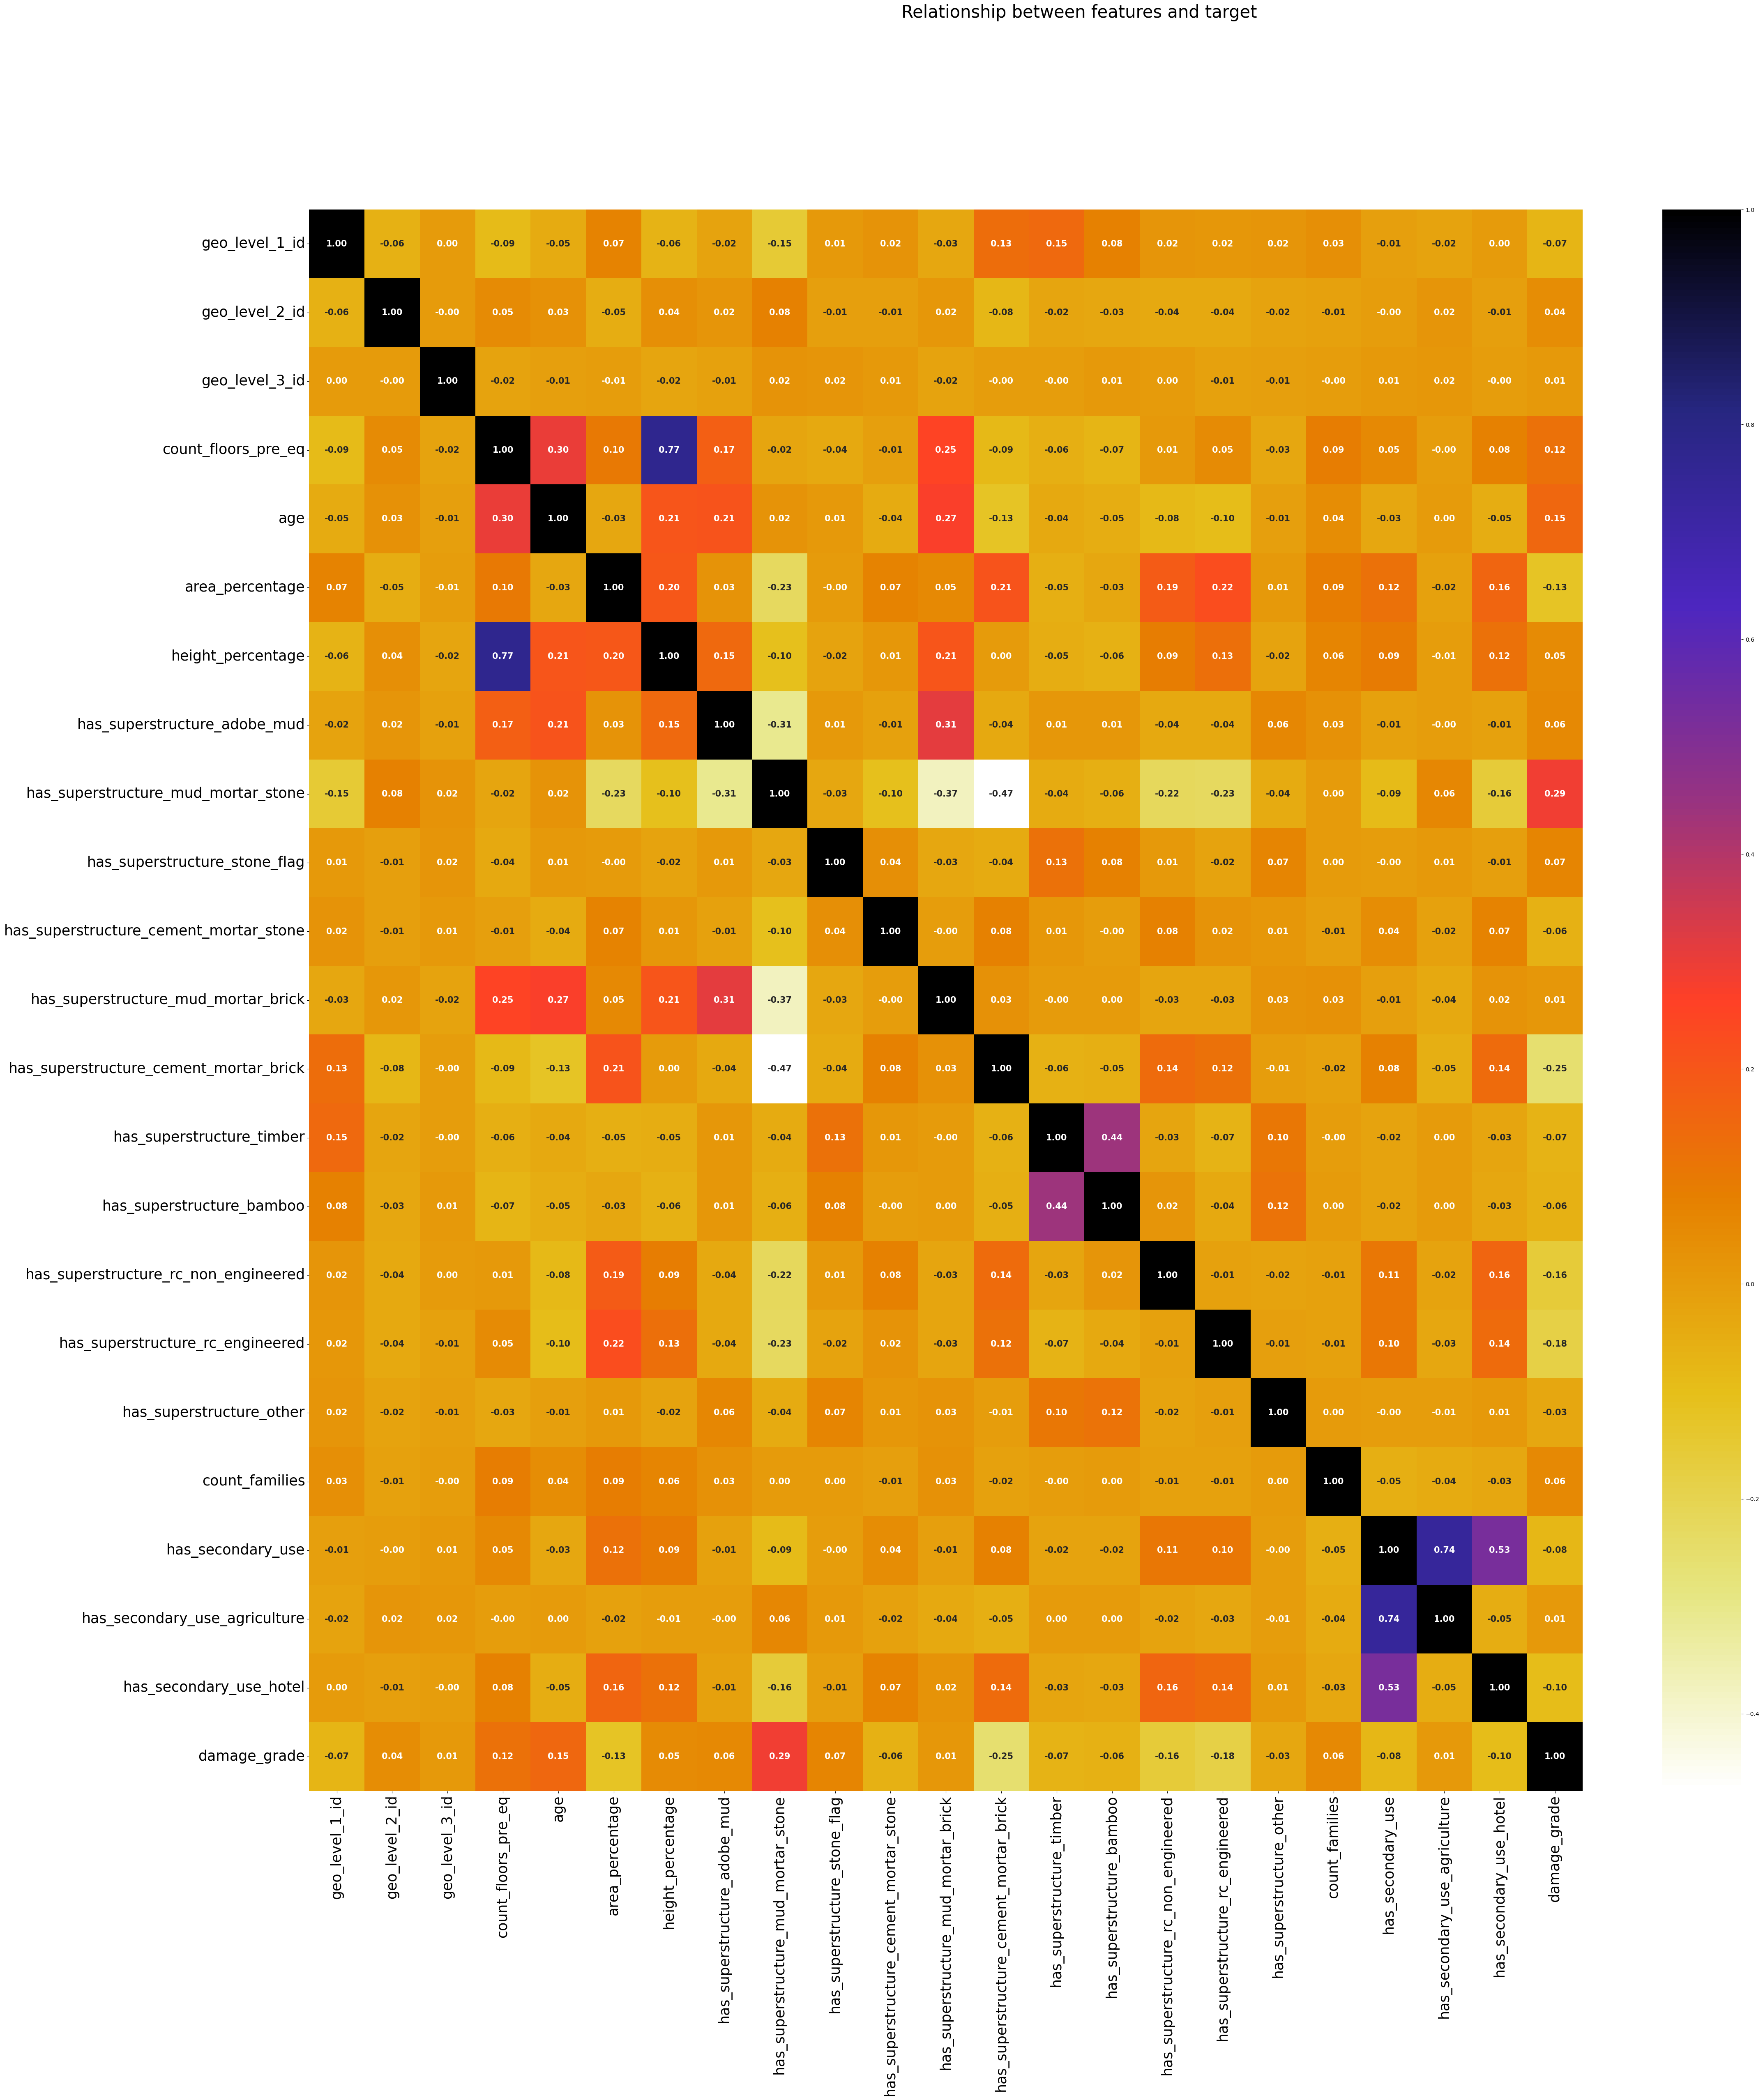

In [ ]:
fig, ax= plt.subplots(figsize=(50,50))
sns.heatmap(df_def.corr(),annot=True,annot_kws={'size': 15,'weight': 'bold'},cmap='CMRmap_r',fmt=".2f")
plt.suptitle("Relationship between features and target",size=30)
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)

plt.show()


In [ ]:
# with the following function we can select highly correlated features
# it will remove the first feature that is correlated with anything other feature

def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

In [ ]:
corr_features=correlation(df_def,0.7)
len(set(corr_features))

2

In [ ]:
corr_features

{'has_secondary_use_agriculture', 'height_percentage'}

In [ ]:
df_def.drop(corr_features,axis=1,inplace=True)
df_test.drop(corr_features,axis=1,inplace=True)

In [ ]:
df_def.shape

(258867, 29)

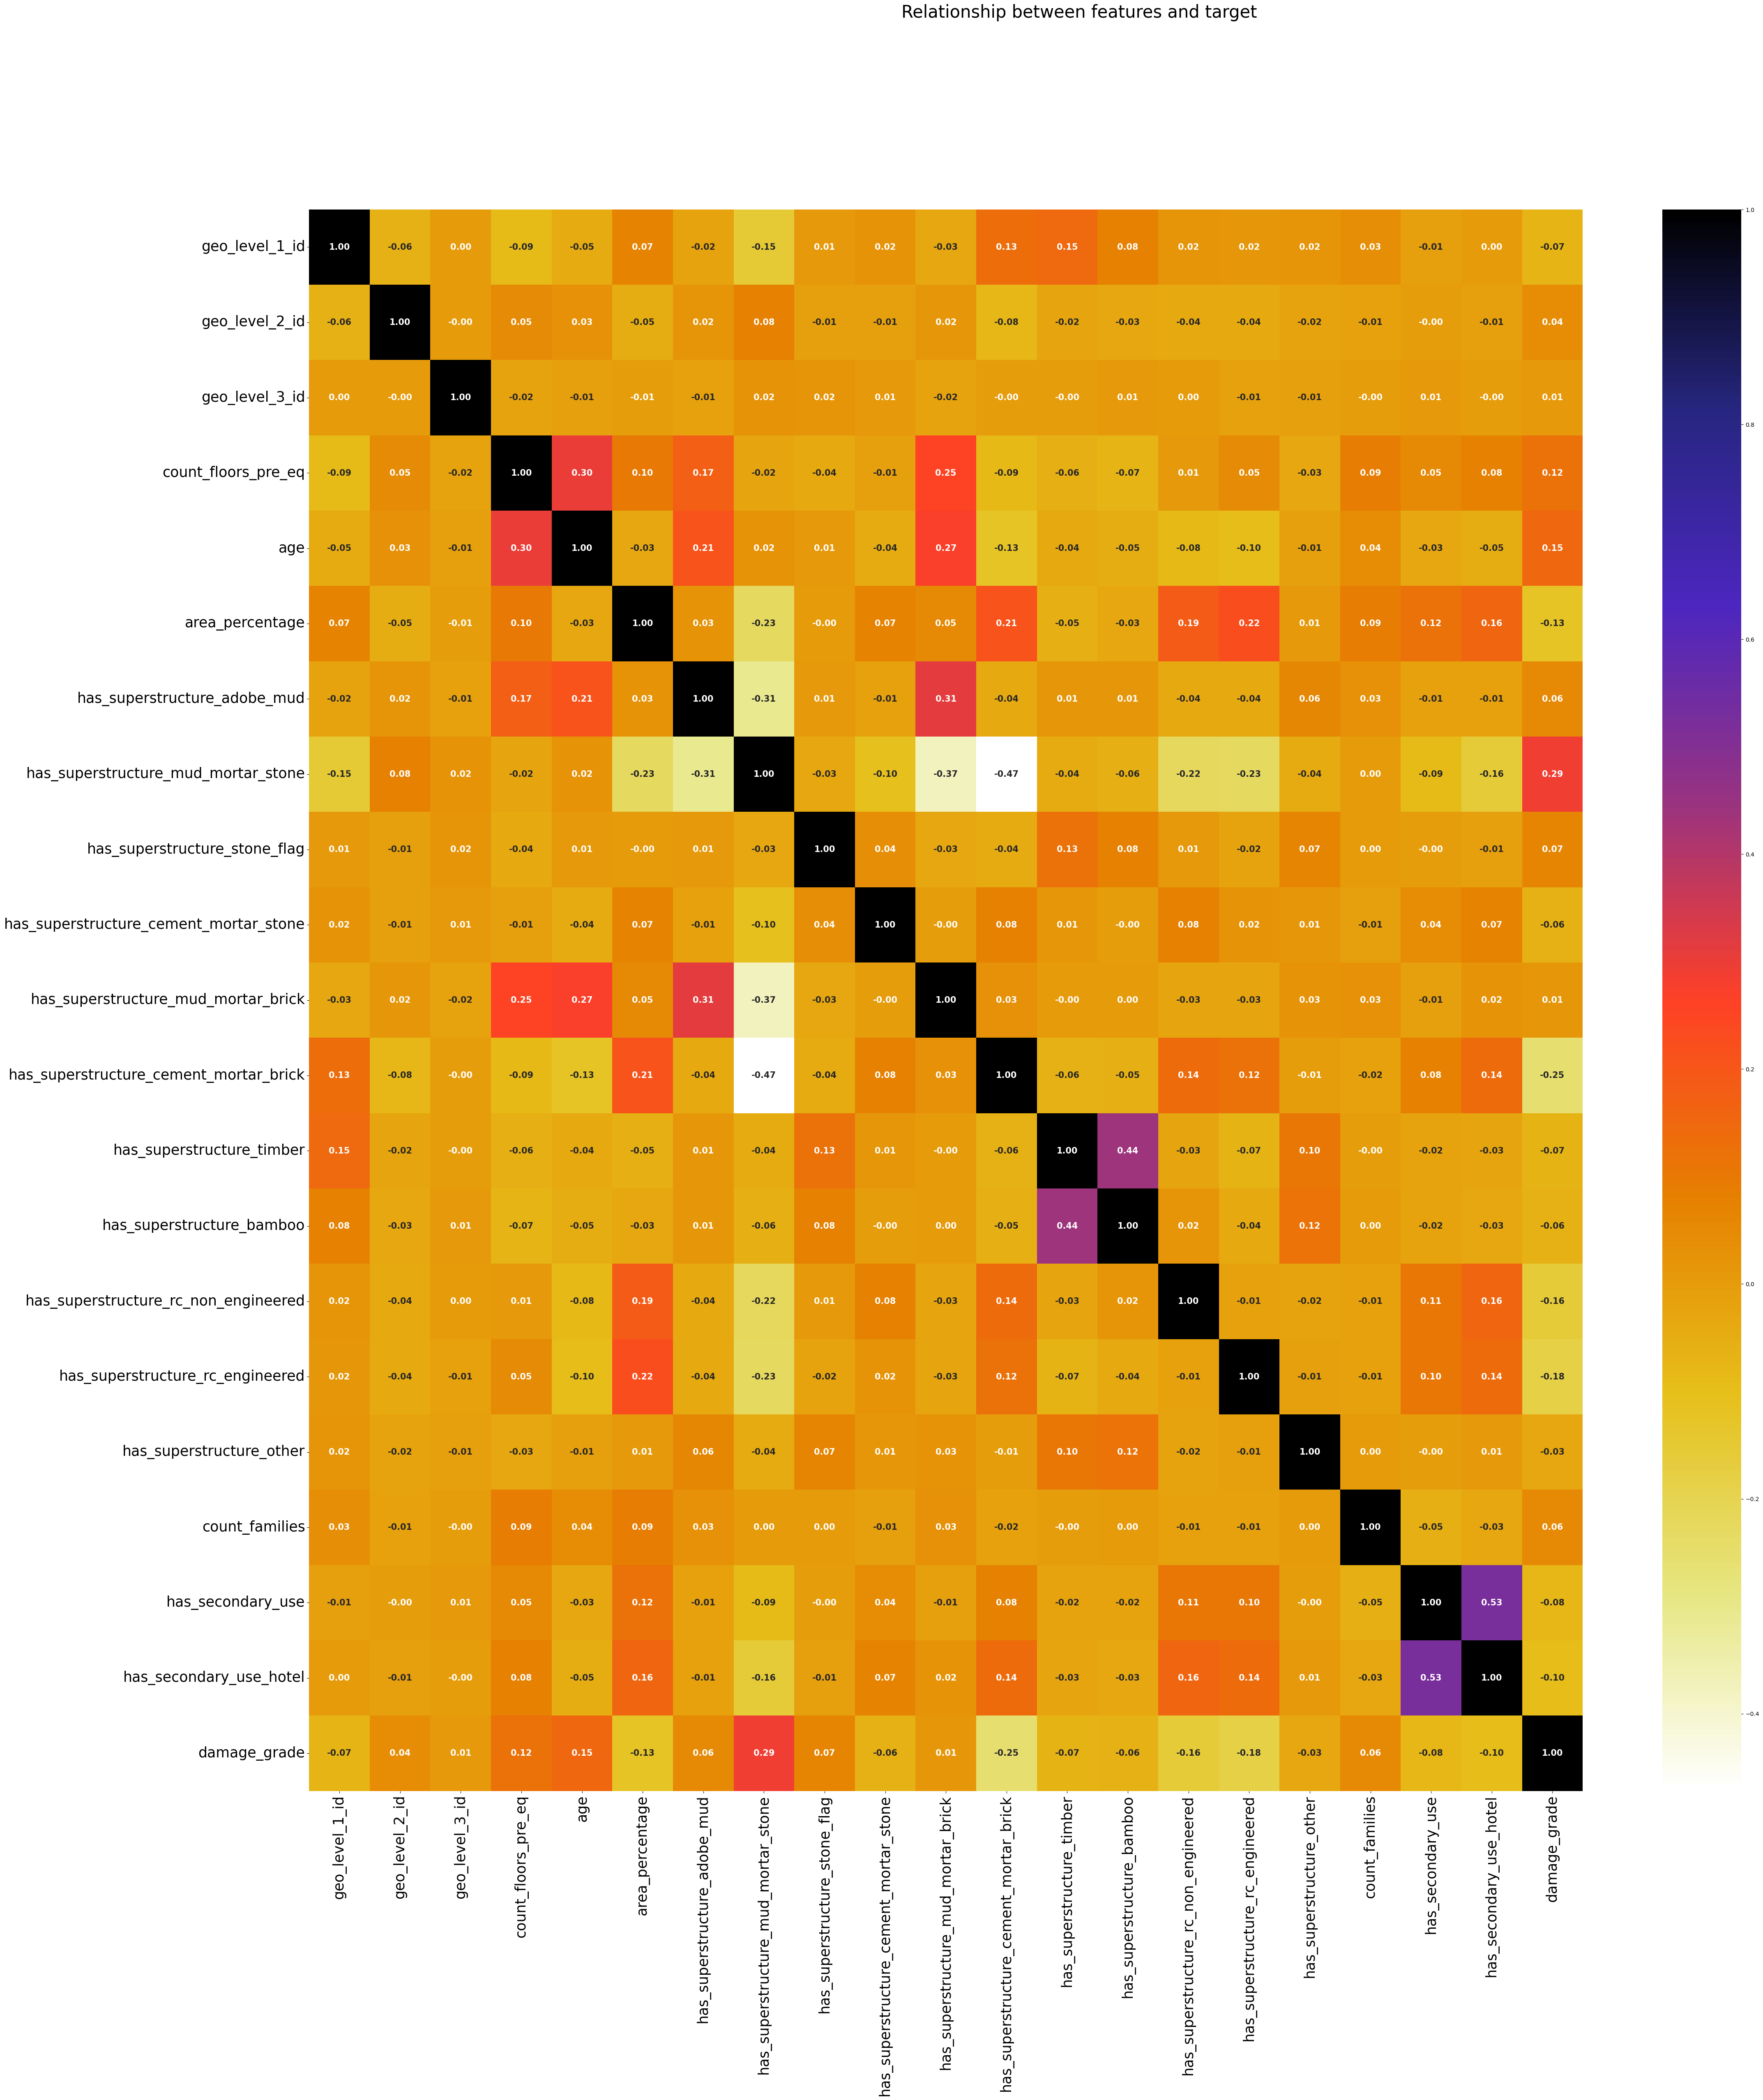

In [ ]:
fig, ax= plt.subplots(figsize=(50,50))
sns.heatmap(df.corr(),annot=True,annot_kws={'size': 15,'weight': 'bold'},cmap='CMRmap_r',fmt=".2f")
plt.suptitle("Relationship between features and target",size=30)
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)

plt.show()

In [ ]:
oversample = SMOTE()

X = df_def.drop(['damage_grade'],axis=1)
y = df_def['damage_grade']




In [ ]:
#num_cols =X.select_dtypes(np.number).columns

#Standard Scaler and transform

#num_transformer = StandardScaler()


#X[num_cols]=num_transformer.fit_transform(X[num_cols])
#df_test[num_cols]=num_transformer.fit_transform(df_test[num_cols])






In [ ]:
X, y = oversample.fit_resample(X, y)

ValueError: could not convert string to float: 't'

In [ ]:
X.shape

(441630, 24)

In [ ]:
X_train, X_test, y_train, y_test= train_test_split(X,y,test_size=0.25,random_state=42)

In [ ]:
#clf = tree.DecisionTreeClassifier()

#clf.fit(X_train,y_train)

#predictions = clf.predict(X_test)

#f1_score_pred = f1_score(y_test,predictions,average='micro')

#print('f1_score_predictions: ',f1_score_pred)

f1_score_predictions:  0.7633323672197667


In [ ]:
clf2 = GradientBoostingClassifier(n_estimators=100,min_samples_split=200, learning_rate=0.4, max_depth=7, random_state=42).fit(X_train, y_train)

predictions2 = clf2.predict(X_test)

f1_score_pred2 = f1_score(y_test,predictions2,average='micro')

print('f1_score_predictions: ',f1_score_pred2)

f1_score_predictions:  0.7985743786682125


In [ ]:
predictions2b = clf2.predict(X_train)

f1_score_pred2b = f1_score(y_train,predictions2b,average='micro')

print('f1_score_predictions: ',f1_score_pred2b)

f1_score_predictions:  0.8217087029243226


In [ ]:
predictions = clf2.predict(df_test)

In [ ]:
submission_format = pd.read_csv('data/submission_format.csv', index_col='building_id')

In [ ]:
my_submission = pd.DataFrame(data=predictions,
                             columns=submission_format.columns,
                             index=submission_format.index)

In [ ]:
my_submission.head()

damage_grade
building_id              
300051                  3
99355                   2
890251                  2
745817                  1
421793                  3

In [ ]:
my_submission.to_csv('submission3.csv')